In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import regex as re
from textstat.textstat import textstat
from textblob import TextBlob
from spellchecker import SpellChecker
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import torch
import transformers
from transformers import pipeline
import itertools
from sklearn.model_selection import cross_val_score

In [6]:
sns.set_theme(style="whitegrid")

# Main Dataset

# Conversation Data

df = pd.read_json(
    "data/chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [9]:
# Auxiliary Datasets

# Embedding Data
prompt_embeddings = np.load(
    "data/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "data/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data
topic_and_hardness = pd.read_json(
    "data/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [10]:
# Extracting the prompt
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)
df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

In [11]:
# Add columns to separate responses from the conversation
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_a_response"][2]

'Both Fuji and Nikon are popular camera brands that offer a wide range of cameras for different types of photography. It really depends on your specific needs and preferences as to which brand is "better" for you.\n\nFujifilm is known for its high image quality, especially in the areas of color accuracy and dynamic range. Many photographers also appreciate the company\'s focus on ergonomics and the overall user experience of its cameras. Additionally, Fujifilm has a loyal following among enthusiasts and professional photographers, thanks to its commitment to film photography and its high-end mirrorless cameras.\n\nNikon, on the other hand, is known for its advanced autofocus system and image stabilization technology, as well as its high-end cameras and lenses. Nikon also has a wide selection of cameras and lenses to choose from, including both DSLR and mirrorless options.\n\nUltimately, it\'s difficult to say which brand is "better" without knowing more about your specific needs and pr

#### Establishing a "winner" column to display the outcome of the competition between model a and model b.

In [12]:
df['winner_name'] = np.where(
    df['winner'] == 'model_a', df['model_a'],
    np.where(
        df['winner'] == 'model_b', df['model_b'],
        np.where(
            df['winner'] == 'tie(bothbad)', 'tie(bothbad)',
            df['model_a'] + ' & ' + df['model_b']))
)

In [13]:
# Create one-hot encodings for the winning chatbot model
# This will attribute a value of 1 to the model if that model wins or there is a tie(bothgood), otherwise (model loses or tie both bad), it gives it a 0

df['one_hot_a'] = np.where(
    (df['winner'] == 'model_a') | (df['winner'] == 'tie'), 1, 0)

df['one_hot_b'] = np.where(
    (df['winner'] == 'model_b') | (df['winner'] == 'tie'), 1, 0)


In [14]:
# Create columns for prompt and response lengths
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe() # Assess statistics of prompt length
df["response_a_length"] = df["model_a_response"].str.len()


df["response_b_length"] = df["model_b_response"].str.len()


<Axes: xlabel='prompt_length', ylabel='Count'>

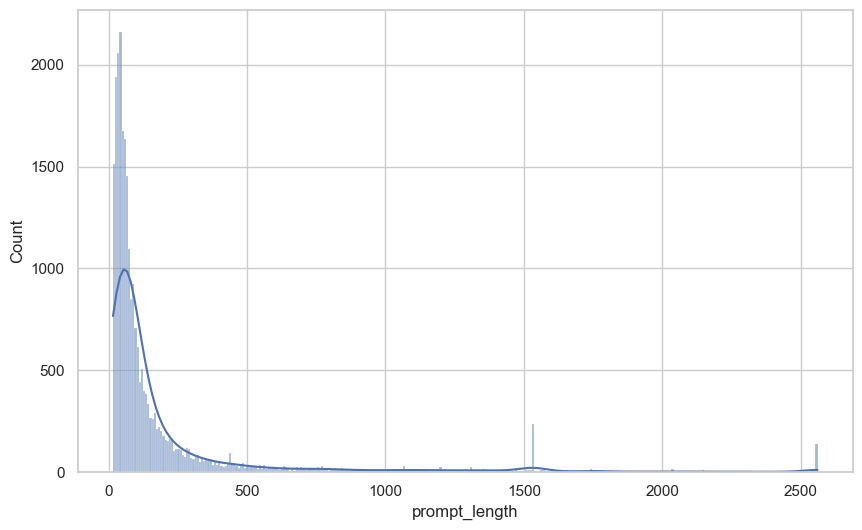

In [15]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)

In [16]:
# Descriptional statistics for the response lengths and prompts
df["response_b_length"].describe()
df["response_b_length"].median()
df["response_b_length"].unique()
df["response_a_length"].describe()
df["response_a_length"].median()
df["response_a_length"].unique()

df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

Text(0, 0.5, 'Count')

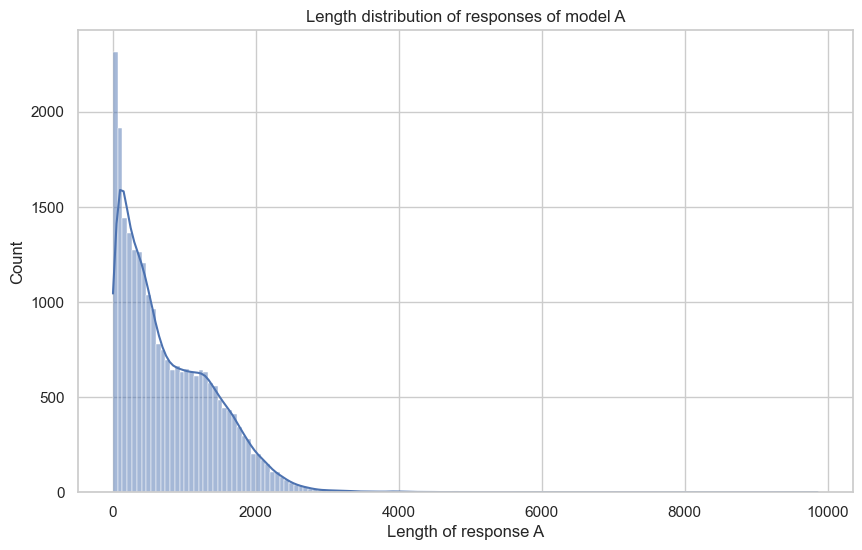

In [17]:
# Plot the distribution of the length of the responses
plt.figure(figsize=(10, 6))
sns.histplot(df["response_a_length"], kde=True)
plt.title("Length distribution of responses of model A")
plt.xlabel("Length of response A")
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

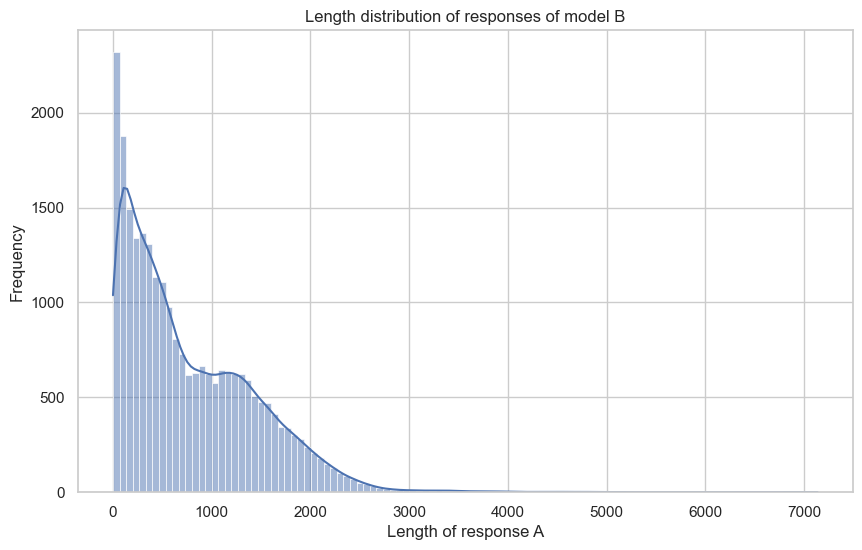

In [18]:
# Plot the distribution of the length of the responses
plt.figure(figsize=(10, 6))
sns.histplot(df["response_b_length"], kde=True)
plt.title("Length distribution of responses of model B")
plt.xlabel("Length of response A")
plt.ylabel("Frequency")

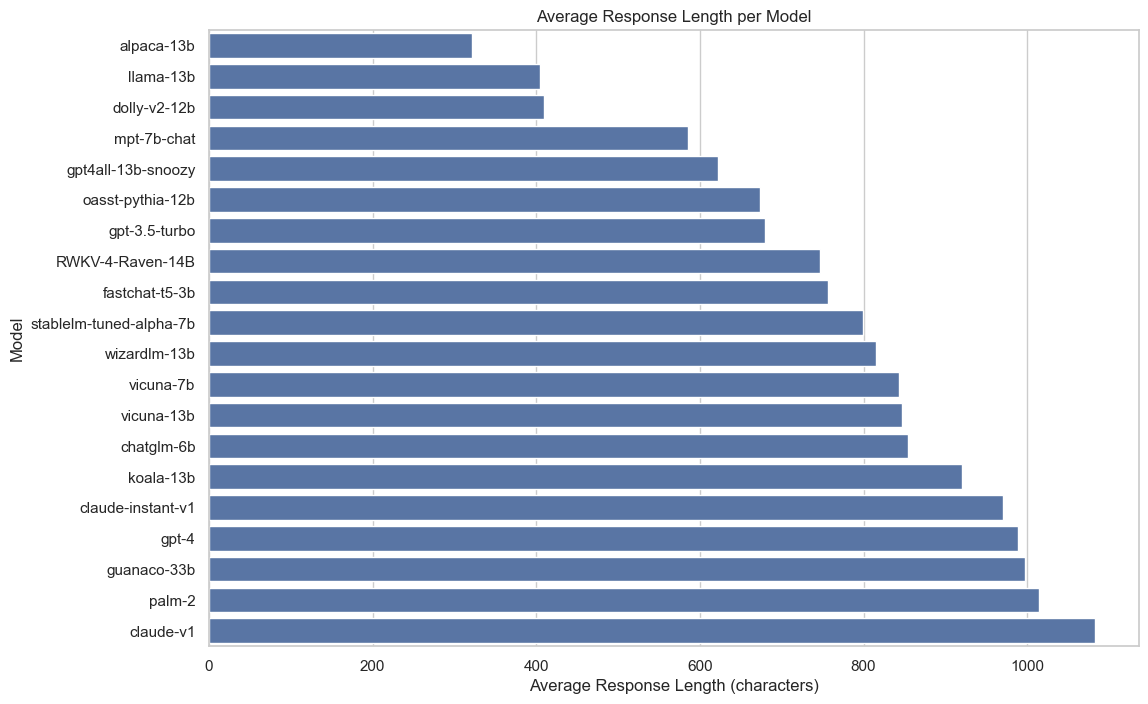

In [21]:
# Visualizing the average response lengths between models
# Stack the response lengths and models into one DataFrame
stacked_df = pd.concat([
    df[['model_a', 'response_a_length']].rename(columns={'model_a': 'model', 'response_a_length': 'response_length'}),
    df[['model_b', 'response_b_length']].rename(columns={'model_b': 'model', 'response_b_length': 'response_length'})
])

# Calculate average response length per model
model_avg_response_length = stacked_df.groupby('model')['response_length'].mean().sort_values()

# Plot the average response length per model
plt.figure(figsize=(12, 8))
sns.barplot(x=model_avg_response_length.values, y=model_avg_response_length.index)
plt.title("Average Response Length per Model")
plt.xlabel("Average Response Length (characters)")
plt.ylabel("Model")
plt.show()

### Engineering feature of dot product similarity between embeddings

In [22]:
assert len(prompt_embeddings) == len(df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(df), "Mismatch between response_b embeddings and DataFrame rows."

# Compute dot products and add them as new columns to the original DataFrame
df['similarity_prompt_response_a'] = [
    np.dot(prompt, response_a)
    for prompt, response_a in zip(prompt_embeddings, response_a_embeddings)
]

df['similarity_prompt_response_b'] = [
    np.dot(prompt, response_b)
    for prompt, response_b in zip(prompt_embeddings, response_b_embeddings)
]


#### Converting the score_value_"n" columns, in topic_and_hardness dataframe, to numeric values and stored in the column "hardness_score"

In [23]:
#convert hardness scores from list to numeric
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [24]:
topic_and_hardness.drop_duplicates(subset='question_id', inplace=True)

In [25]:
# Merge the mean value of the hardness scores, as well as the topic_modeling 3 with the main data set
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

In [26]:
nan_rows = topic_and_hardness[topic_and_hardness['hardness_score'].isna()]
nan_rows['prompt']
print(len(nan_rows))

59


In [27]:
# Removing question ids that produce null values and storing the final dataset into filtered_df

filtered_df = merged_df.dropna(subset=['hardness_score'])

#### Exploring the topic modeling and hardness score datasets

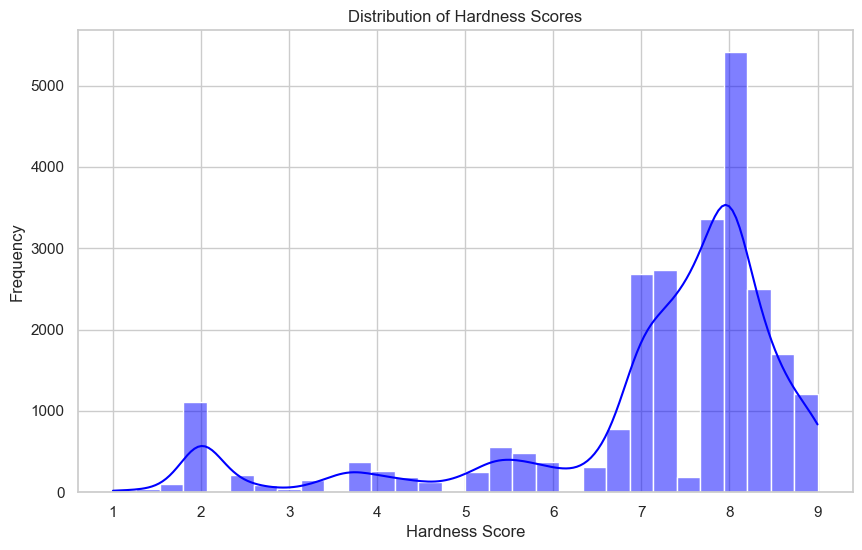

In [28]:
# Plot the hardness score distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["hardness_score"], bins=30, kde=True, color="blue")
plt.title("Distribution of Hardness Scores")
plt.xlabel("Hardness Score")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'Amount of topics with that frequency')

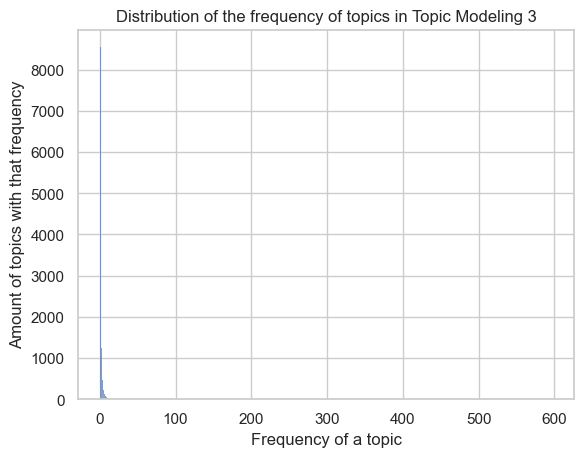

In [29]:
# Count the unique topics and plot a histogram
topic3_counts=merged_df["topic_modeling_3"].value_counts()
topic3_counts
sns.histplot(topic3_counts, binwidth=1)
plt.title("Distribution of the frequency of topics in Topic Modeling 3")
plt.xlabel("Frequency of a topic")
plt.ylabel("Amount of topics with that frequency")

In [30]:
# Count unique topics
len(topic3_counts)

# Get the most frequently occurring topics
topic3_counts[0:30]

topic_modeling_3
Creative Writing                     596
Factual Accuracy                     487
Problem-solving, Creativity          407
Factual Knowledge                    314
Problem Solving                      290
Math Problem                         206
Information Retrieval                197
Problem-solving, Factual accuracy    174
Problem-Solving, Creativity          158
Creativity, Humor                    145
Decision Making                      113
Logic Puzzle                         105
Problem-Solving                      102
Creativity, Factual Accuracy          89
Creativity, Problem-solving           87
Mathematical Calculation              81
Philosophical Inquiry                 80
Comparison Analysis                   74
Factual Recall                        74
Problem-Solving, Factual Accuracy     74
Geography Knowledge                   72
Language Translation                  72
Creative Thinking                     72
Travel Planning                       72

### Create Topic Feature

In [33]:
# Define regex patterns and their corresponding feature names
core_topics = {
    r'math': 'topic_math',
    r'fact\w*': 'topic_fact',
    r'creativ\w*': 'topic_creative',
    r'problem[ -]?solving': 'topic_problem_solving',
}

# Apply one-hot encoding for the defined core topics
for pattern, feature_name in core_topics.items():
    filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

# Check the updated DataFrame
filtered_df.head()

/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/1820580109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/1820580109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,winner_name_id,similarity_prompt_response_a,similarity_prompt_response_b,hardness_score,topic_modeling_3,topic_math,topic_fact,topic_creative,topic_problem_solving,comparison
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,[6],0.751438,0.802665,8.666667,"Comparison, Technology",0,0,0,0,1
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,"[19, 1]",0.751248,0.502628,8.333333,"Reasoning, Emotional",0,0,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,[19],0.815042,0.767400,3.333333,Photography comparison,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,[19],0.829923,0.826861,8.000000,Chatbot Arena,0,0,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,[7],0.364985,0.566376,2.000000,Time-based Inquiry,0,0,0,0,0


### Plot Topic Distribution

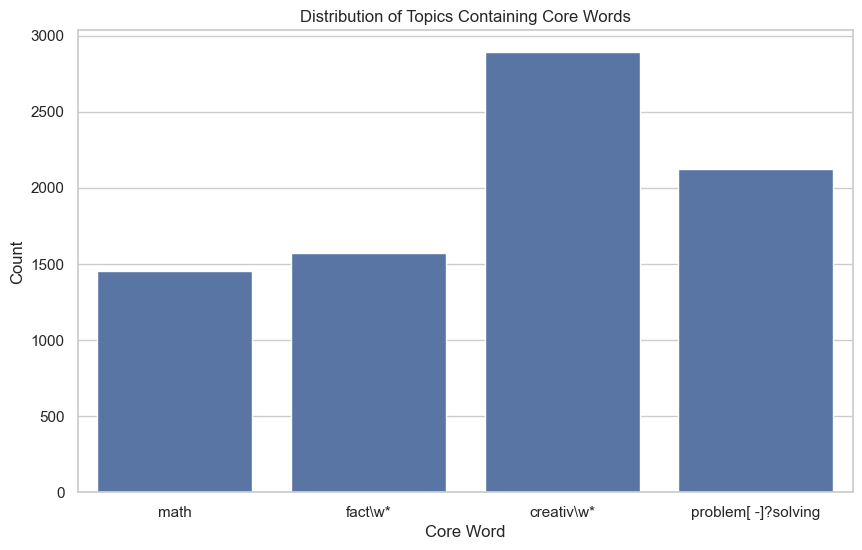

In [34]:
# Calculate topic distribution using regex
topic_distribution = {
    core_topic: (
        merged_df['topic_modeling_3'].str.contains(core_topic, flags=re.IGNORECASE, na=False, regex=True).sum()
    )
    for core_topic in core_topics
}
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(topic_distribution.keys()), y=list(topic_distribution.values()))
plt.title("Distribution of Topics Containing Core Words")
plt.xlabel("Core Word")
plt.ylabel("Count")
plt.show()


#### Calculating the ELO ratings per model:

In [35]:
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)




ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.295292
10                    gpt-4  1250.321864
11                claude-v1  1235.336695
19              guanaco-33b  1124.800975
9             gpt-3.5-turbo  1112.354364
3                vicuna-13b  1109.173648
14                   palm-2  1073.732764
2                 koala-13b  1069.405551
16                vicuna-7b  1050.647481
17             wizardlm-13b   997.282860
13              mpt-7b-chat   969.323150
12         RWKV-4-Raven-14B   936.973934
5                alpaca-13b   928.746627
18       gpt4all-13b-snoozy   926.126606
0                chatglm-6b   888.680752
1          oasst-pythia-12b   884.588399
4   stablelm-tuned-alpha-7b   840.143122
8            fastchat-t5-3b   827.112558
6                 llama-13b   773.676275
7              dolly-v2-12b   709.277081


### Create column where the ELO ratings are compared, model a minus model b, to give a measure of which model is stronger so that we can include the prompt features as well in task A (predicting whether model a or model b will win)

In [36]:
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

# Display the first few rows to verify the new column
filtered_df.columns

/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/403063721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(


Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'winner_name', 'one_hot_a', 'one_hot_b',
       'prompt_length', 'response_a_length', 'response_b_length',
       'winner_name_id', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'topic_math', 'topic_fact', 'topic_creative', 'topic_problem_solving',
       'comparison', 'elo_modela_minus_modelb'],
      dtype='object')

## Auxiliary verbs feature

In [37]:

# Define the modal verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Create a regex pattern (case-insensitive)
modal_regex = '|'.join([re.escape(verb) for verb in modal_verbs])

# Function to one-hot encode the presence of modal verbs
def one_hot_modal_features(df, column_name, modal_regex):
    for verb in modal_verbs:
        pattern = rf'\b{re.escape(verb)}\b'
        df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
    return df

# Apply the function to both model_a_response and model_b_response
filtered_df = one_hot_modal_features(filtered_df, 'model_a_response', modal_regex)
filtered_df = one_hot_modal_features(filtered_df, 'model_b_response', modal_regex)

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/757170161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/757170161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,model_b_response_contains_can,model_b_response_contains_could,model_b_response_contains_may,model_b_response_contains_might,model_b_response_contains_shall,model_b_response_contains_should,model_b_response_contains_will,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,1,0,0,0,0,0,0,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,0,1,0,0,0,0,0,1,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,0,0,1,0,0,0,1,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,1,1,0,0,0,1,1,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Question words feature

# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to,prompt_contains_who,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,0,0,0,0,0,0,0,1,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,1,0,0,0,0,0,1,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,0,0,0,0,0,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,0,0,0,0,0,0,0,0,1,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,0,0,0,0,1,0,0,0,0


### Explore effects of auxiliary verbs & question words on winning model and hardness score

/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/2407115322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model_a_has_auxiliary'] = filtered_df[auxiliary_verb_columns].any(axis=1).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipykernel_13765/2407115322.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['model_b_has_auxiliary'] = filtered_df[auxiliary_verb_columns_b].any(axis=1).astype(int)
/var/folders/dp/n0lqg1mj78dc_630t36222ww0000gn/T/ipyker

<Figure size 1000x600 with 0 Axes>

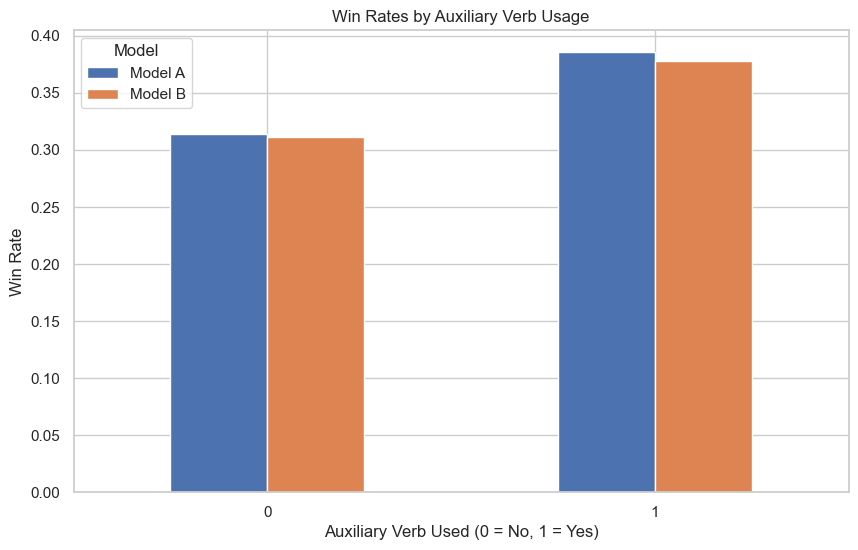

In [39]:
# Plot the effect of any auxiliary verb usage on whether the model wins
# Ensure seaborn style
sns.set(style="whitegrid")

# Check if auxiliary verb columns exist
auxiliary_verb_columns = [col for col in filtered_df.columns if '_contains_' in col and 'model_a_response' in col]

# Add a column to determine whether any auxiliary verb is present in the response
filtered_df['model_a_has_auxiliary'] = filtered_df[auxiliary_verb_columns].any(axis=1).astype(int)

# Repeat for model_b
auxiliary_verb_columns_b = [col for col in filtered_df.columns if '_contains_' in col and 'model_b_response' in col]
filtered_df['model_b_has_auxiliary'] = filtered_df[auxiliary_verb_columns_b].any(axis=1).astype(int)

# Define a column to represent the winning model
# Adjust the column name as per  dataset
filtered_df['model_a_wins'] = (filtered_df['winner'] == 'model_a').astype(int)
filtered_df['model_b_wins'] = (filtered_df['winner'] == 'model_b').astype(int)

# Calculate win rates for responses with and without auxiliary verbs
auxiliary_win_rates = {
    'Model A': filtered_df.groupby('model_a_has_auxiliary')['model_a_wins'].mean(),
    'Model B': filtered_df.groupby('model_b_has_auxiliary')['model_b_wins'].mean()
}
auxiliary_win_df = pd.DataFrame(auxiliary_win_rates)

# Visualize the win rates
plt.figure(figsize=(10, 6))
auxiliary_win_df.plot(kind='bar', figsize=(10, 6))
plt.title('Win Rates by Auxiliary Verb Usage')
plt.xlabel('Auxiliary Verb Used (0 = No, 1 = Yes)')
plt.ylabel('Win Rate')
plt.legend(title='Model')
plt.xticks(rotation=0)
plt.show()


<Figure size 1200x600 with 0 Axes>

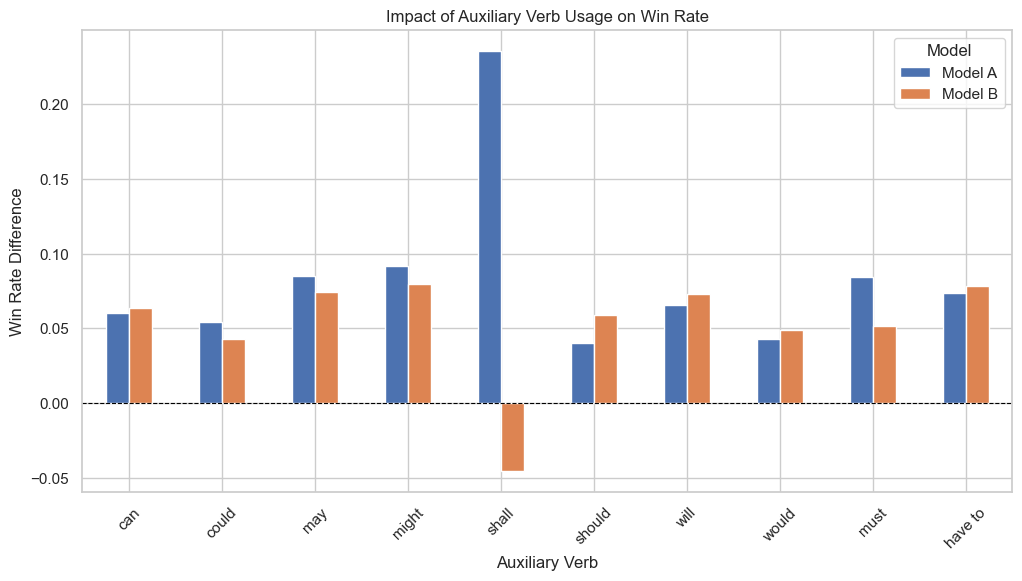

In [40]:
# Plot the effect of auxiliary verbs (modal verbs) on winning model

# Initialize dictionaries to store results
model_a_win_diff = {}
model_b_win_diff = {}

# Calculate win rate differences for each auxiliary verb
for verb in modal_verbs:
    # Regex pattern to match the auxiliary verb (case insensitive)
    pattern = rf'\b{verb}\b'
    
    # Model A: Rows where the auxiliary verb is used and not used
    model_a_with_verb = filtered_df[filtered_df['model_a_response'].str.contains(pattern, case=False, na=False)]
    model_a_without_verb = filtered_df[~filtered_df['model_a_response'].str.contains(pattern, case=False, na=False)]
    
    # Model B: Rows where the auxiliary verb is used and not used
    model_b_with_verb = filtered_df[filtered_df['model_b_response'].str.contains(pattern, case=False, na=False)]
    model_b_without_verb = filtered_df[~filtered_df['model_b_response'].str.contains(pattern, case=False, na=False)]
    
    # Calculate win rates for with and without the auxiliary verb
    model_a_win_rate_with = model_a_with_verb['winner'].eq('model_a').mean()
    model_a_win_rate_without = model_a_without_verb['winner'].eq('model_a').mean()
    model_b_win_rate_with = model_b_with_verb['winner'].eq('model_b').mean()
    model_b_win_rate_without = model_b_without_verb['winner'].eq('model_b').mean()
    
    # Store the difference in win rates
    model_a_win_diff[verb] = model_a_win_rate_with - model_a_win_rate_without
    model_b_win_diff[verb] = model_b_win_rate_with - model_b_win_rate_without

# Create a DataFrame for visualization
win_diff_df = pd.DataFrame({
    'Model A': model_a_win_diff,
    'Model B': model_b_win_diff
})

# Plot the win rate differences
plt.figure(figsize=(12, 6))
win_diff_df.plot(kind='bar', figsize=(12, 6))
plt.title('Impact of Auxiliary Verb Usage on Win Rate')
plt.xlabel('Auxiliary Verb')
plt.ylabel('Win Rate Difference')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a baseline at 0
plt.show()


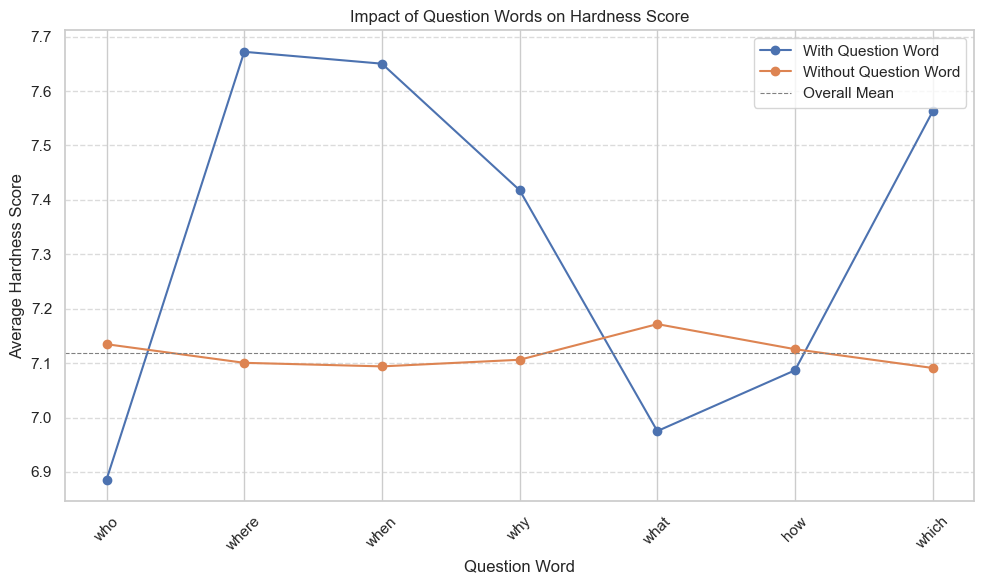

In [41]:
# Plot the effect of question words on hardness score

# Initialize a dictionary to store average hardness scores
hardness_scores = {'With': [], 'Without': []}

# Calculate the average hardness score for prompts with and without each question word
for word in question_words:
    column_name = f'prompt_contains_{word}'
    with_word = filtered_df[filtered_df[column_name] == 1]['hardness_score'].mean()
    without_word = filtered_df[filtered_df[column_name] == 0]['hardness_score'].mean()
    hardness_scores['With'].append(with_word)
    hardness_scores['Without'].append(without_word)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(question_words, hardness_scores['With'], marker='o', label='With Question Word')
plt.plot(question_words, hardness_scores['Without'], marker='o', label='Without Question Word')
plt.title('Impact of Question Words on Hardness Score')
plt.xlabel('Question Word')
plt.ylabel('Average Hardness Score')
plt.xticks(rotation=45)
plt.axhline(filtered_df['hardness_score'].mean(), color='gray', linestyle='--', linewidth=0.8, label='Overall Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [44]:
filtered_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'winner_name', 'one_hot_a', 'one_hot_b',
       'prompt_length', 'response_a_length', 'response_b_length',
       'winner_name_id', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'topic_math', 'topic_fact', 'topic_creative', 'topic_problem_solving',
       'comparison', 'elo_modela_minus_modelb',
       'model_a_response_contains_can', 'model_a_response_contains_could',
       'model_a_response_contains_may', 'model_a_response_contains_might',
       'model_a_response_contains_shall', 'model_a_response_contains_should',
       'model_a_response_contains_will', 'model_a_response_contains_would',
       'model_a_response_contains_must', 'model_a_response_contains_have_to',
       'model_b_response_contains_can', 'model_b_response_contains_could',
       'model

In [45]:
filtered_df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which,model_a_has_auxiliary,model_b_has_auxiliary,model_a_wins,model_b_wins
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,0,0,0,1,0,0,1,1,0,1
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,0,0,1,0,0,0,1,1,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,0,0,0,0,0,1,1,1,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,0,0,0,0,1,0,1,1,0,1
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,1,0,0,0,0,1,0,1,0


### We have performed more EDA in the individual model notebooks. For example, we checked correlation between features and between the features & hardness score and feature & winning model, in the notebook for model A. 